In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv("innovize_final_ml.csv")
df.head()

,phy_fitness,diet_pref,act_level,sleep_hrs,mindfulness,career,gender,daily_avg_steps,daily_avg_calories,is_healthy
0,3.0,Vegan,Sedentary,7,10,Artist,1.0,2020.0,1831.0,0
1,4.0,Vegan,Lightly Active,7,1,Teacher,0.0,5154.0,2190.0,0
2,8.0,Vegetarian,Active,8,10,Freelancer,1.0,12363.0,2297.0,1
3,2.0,Pescatarian,Sedentary,8,7,Doctor,0.0,1664.0,1943.0,0
4,9.0,Pescatarian,Highly Active,5,7,Business,0.0,17680.0,3527.0,1


In [3]:
df.shape

(6000, 10)

In [4]:
df.isnull().sum()

,0
phy_fitness,3
diet_pref,4
act_level,6
sleep_hrs,0
mindfulness,0
career,4
gender,1
daily_avg_steps,11
daily_avg_calories,14
is_healthy,0


In [5]:
num_cols = ['phy_fitness', 'sleep_hrs', 'mindfulness', 'daily_avg_steps', 'daily_avg_calories']
cat_cols = ['diet_pref', 'act_level', 'career', 'gender']

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df[cat_cols] = df[cat_cols].astype(str).fillna("Unknown")

In [6]:
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [7]:
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [8]:
df.isnull().sum()

,0
phy_fitness,0
diet_pref,0
act_level,0
sleep_hrs,0
mindfulness,0
career,0
gender,0
daily_avg_steps,0
daily_avg_calories,0
is_healthy,0


In [9]:
encoders = {}
for c in cat_cols:
    encoders[c] = LabelEncoder()
    df[c] = encoders[c].fit_transform(df[c])

In [10]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [11]:
df.head()

,phy_fitness,diet_pref,act_level,sleep_hrs,mindfulness,career,gender,daily_avg_steps,daily_avg_calories,is_healthy
0,-0.845195,3,3,-0.007309,1.539919,0,1,-1.270825,-0.876875,0
1,-0.498882,3,2,-0.007309,-1.589056,9,0,-0.703046,-0.314275,0
2,0.886370,4,0,0.700052,1.539919,4,1,0.602991,-0.146592,1
3,-1.191508,2,3,0.700052,0.496928,2,0,-1.335321,-0.701356,0
4,1.232683,2,1,-1.422032,0.496928,1,0,1.566259,1.780978,1


In [12]:
df['fitness_x_act'] = df['phy_fitness'] * df['act_level']
df['sleep_mind'] = df['sleep_hrs'] * df['mindfulness']
df['steps_cal_ratio'] = df['daily_avg_steps'] / (df['daily_avg_calories'] + 1e-6)

In [13]:
X = df.drop('is_healthy', axis=1)
y = df['is_healthy']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
print("Train", np.bincount(y_train))
print("Test", np.bincount(y_test))

Train [3286 1514]
Test [822 378]


In [34]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [9, 12],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}

In [35]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 128 candidates, totalling 384 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:34:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [38]:
print("Best params", grid_search.best_params_)

Best params {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


In [37]:
y_pred = best_xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)

acc

print("Test accuracy " + str(acc*100) + "%")

Test accuracy 99.5%


In [20]:
import pickle

In [21]:
filename = 'final_model.sav'
pickle.dump(best_xgb, open(filename, 'wb'))

In [22]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result*100)

99.5


In [23]:
X_sub = X_train[['phy_fitness', 'mindfulness']]

In [24]:
model_sub = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_sub.fit(X_sub, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [25]:
x_min, x_max = X_sub['phy_fitness'].min() - 0.1, X_sub['phy_fitness'].max() + 0.1
y_min, y_max = X_sub['mindfulness'].min() - 0.1, X_sub['mindfulness'].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

In [26]:
Z = model_sub.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

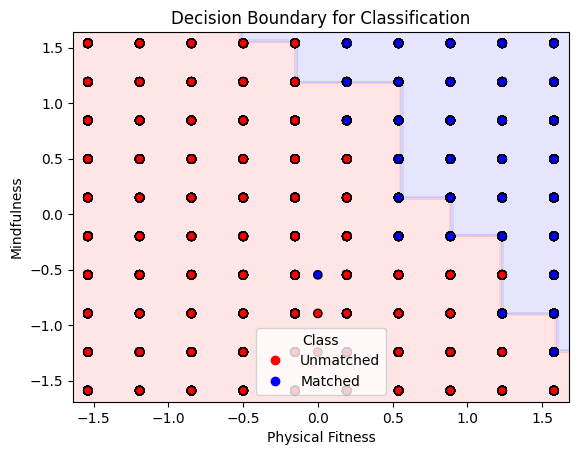

In [27]:
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)
scatter = plt.scatter(X_sub['phy_fitness'], X_sub['mindfulness'], c=y_train, cmap=cmap_points, edgecolor='k')

plt.xlabel("Physical Fitness")
plt.ylabel("Mindfulness")
plt.title("Decision Boundary for Classification")

labels = {0: 'Unmatched', 1: 'Matched'}
plt.legend(handles=scatter.legend_elements()[0], labels=labels.values(), title="Class")
plt.show()